<a href="https://colab.research.google.com/github/ziri4k/ML-Prediction-of-Stress-in-Aircraft-Turbine-blades-WASPALOY-IN7/blob/main/IN7main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INCONEL 718 FOR AIRCRAFT TURBINE


this is to predict stress that will result to break of the alloy

In [ ]:
# Use seaborn for pairplot.
!pip install -q seaborn

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import files

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.12.0


In [ ]:
#The data is fed into
uploaded = files.upload()
dataset = pd.read_csv("newproj3.csv")
df= dataset

Saving newproj3.csv to newproj3.csv


In [ ]:
dataset.head()


,strain,temperature,strainrate,stress
0,0.00,-180,4000,513
1,0.05,-180,4000,1086
2,0.10,-180,4000,1423
3,0.15,-180,4000,1599
4,0.20,-180,4000,1671


In [ ]:
dataset.tail()

,strain,temperature,strainrate,stress
259,0.30,750,7500,757
260,0.35,750,7500,707
261,0.40,750,7500,689
262,0.45,750,7500,728
263,0.50,750,7500,845


SPLIT INTO TRAIN AND TEST SET

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Inspect the data

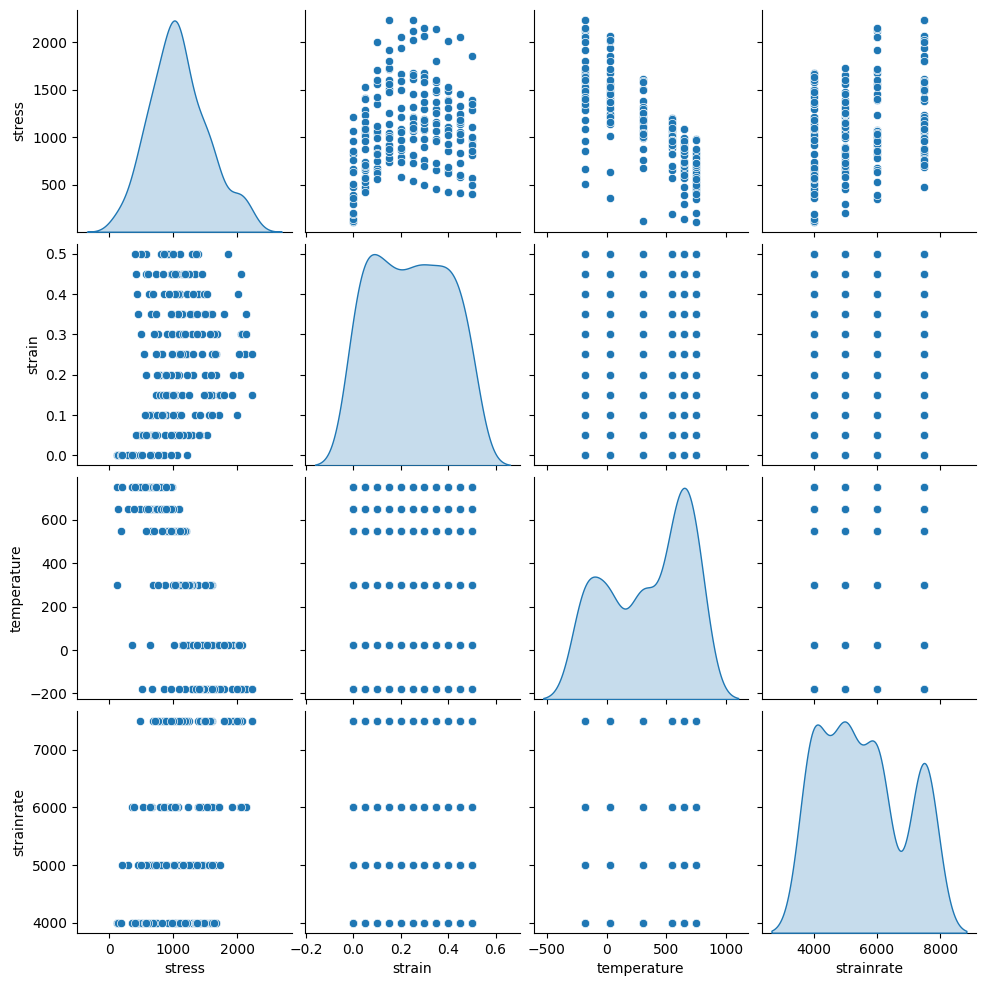

In [ ]:
sns.pairplot(train_dataset[['stress', 'strain', 'temperature', 'strainrate']], diag_kind='kde')

In [ ]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
strain,211.0,0.240995,0.156493,0.0,0.1,0.25,0.4,0.5
temperature,211.0,345.805687,338.749191,-180.0,25.0,300.00,650.0,750.0
strainrate,211.0,5568.720379,1293.304285,4000.0,4000.0,5000.00,6000.0,7500.0
stress,211.0,1089.587678,450.347734,113.0,789.5,1060.00,1376.5,2235.0


Split features from labels

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('stress')
test_labels = test_features.pop('stress')

**Normalization**

In [ ]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
strain,0.240995,0.156493
temperature,345.805687,338.749191
strainrate,5568.720379,1293.304285
stress,1089.587678,450.347734


create new layer

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)

fit the state of the preprocessing layer

In [ ]:
normalizer.adapt(np.array(train_features))

mean and variance and store them in the layer

In [ ]:
print(normalizer.mean.numpy())

[[   0.241  345.806 5568.72 ]]


when called returns input data with normalized

In [ ]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   0.2 -180.  6000. ]]

Normalized: [[-0.26 -1.56  0.33]]


Build the Keras Sequential model

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.1))
  return model

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 3)                7         
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________


In [ ]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=300)

CPU times: user 17.1 s, sys: 502 ms, total: 17.6 s
Wall time: 42.8 s


visualizing model training progress

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
295,104.393669,74.093719,295
296,90.831757,78.791710,296
297,89.791275,87.175034,297
298,90.312103,70.209549,298
299,81.745300,93.550720,299


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 700])
  plt.xlabel('Epoch')
  plt.ylabel('Error [stress]')
  plt.legend()
  plt.grid(True)

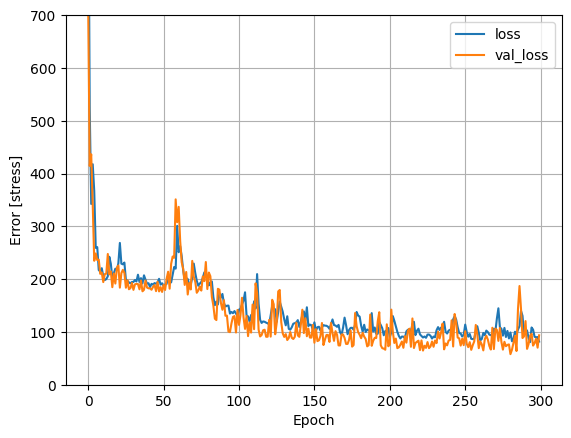

In [ ]:
plot_loss(history)

In [ ]:
test_results = {}

In [ ]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [stress]']).T

,Mean absolute error [stress]
dnn_model,116.018028


Stress

2/2 [==============================] - 0s 10ms/step


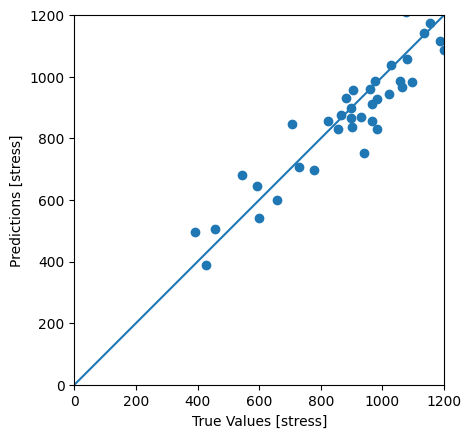

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()
datasets= test_dataset['stress']

a = plt.axes(aspect='equal')
plt.scatter(datasets, test_predictions)
plt.xlabel('True Values [stress]')
plt.ylabel('Predictions [stress]')
lims = [0, 1200]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


Strain rate

2/2 [==============================] - 0s 19ms/step


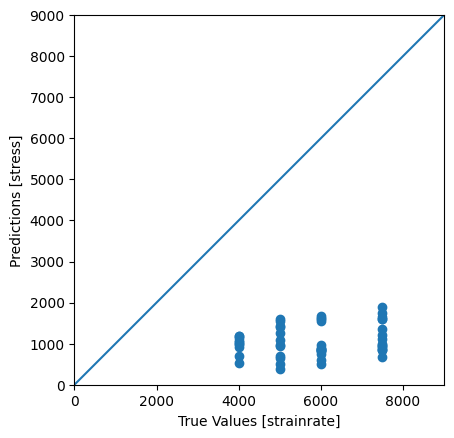

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()
datasets= test_dataset['strainrate']

a = plt.axes(aspect='equal')
plt.scatter(datasets, test_predictions)
plt.xlabel('True Values [strainrate]')
plt.ylabel('Predictions [stress]')
lims = [0, 9000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Temperature

2/2 [==============================] - 0s 11ms/step


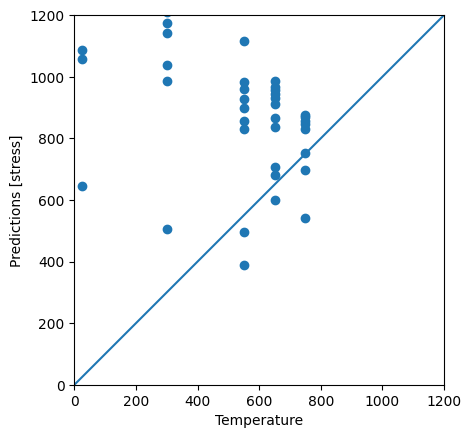

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()
datasets= test_dataset['temperature']

a = plt.axes(aspect='equal')
plt.scatter(datasets, test_predictions)
plt.xlabel('Temperature')
plt.ylabel('Predictions [stress]')
lims = [0, 1200]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Strain

2/2 [==============================] - 0s 11ms/step


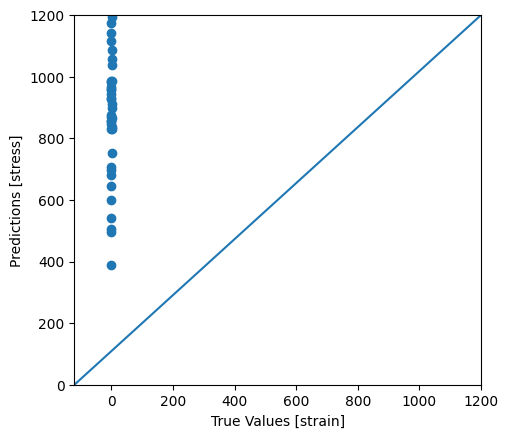

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()
datasets= test_dataset['strain']

a = plt.axes(aspect='equal')
plt.scatter(datasets, test_predictions)
plt.xlabel('True Values [strain]')
plt.ylabel('Predictions [stress]')
lims = [-120, 1200]
lim = [0,1200]
plt.xlim(lims)
plt.ylim(lim)
_ = plt.plot(lims, lim)